# カフェのサービス評価実験 - 分析

## ライブラリとデータの挿入と整理

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
original = pd.read_csv("data.csv", header=0)

In [11]:
fa_data = original.iloc[:, 2:24]
aov_data = original.iloc[:, 24:]

## 因子分析

###  数値変換

In [12]:
for i in range(len(fa_data.columns)):
    if "ない" in fa_data.columns[i]:
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("強くそう思う", "1")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思う", "3")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思う", "2")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("どちらともいえない", "4")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思わない", "5")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("全くそう思わない", "7")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思わない", "6")
    else:
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("強くそう思う", "7")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思う", "5")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思う", "6")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("どちらともいえない", "4")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("ややそう思わない", "3")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("全くそう思わない", "1")
        fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].str.replace("そう思わない", "2")
        
    fa_data = fa_data.rename({str(fa_data.columns[i]):"X"+str(i+1)}, axis="columns")
    fa_data[fa_data.columns[i]] = fa_data[fa_data.columns[i]].astype(int)

In [13]:
fa_data.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22
count,19,19,19,19,19,19,19,19,19,19,...,19,19,19,19,19,19,19,19,19,19
mean,5,4.21053,5.68421,4.10526,5.73684,4.63158,4.31579,6.05263,5.26316,3,...,4.31579,4.73684,4.52632,6.21053,5.05263,4.10526,4.15789,4.78947,4,4.15789
std,1.85592,1.54844,1.66842,1.79179,1.24017,1.97795,1.73374,1.17727,1.408,1.69967,...,1.94515,1.6945,2.1697,1.18223,1.74718,1.82254,2.03479,2.04339,1.97203,1.06787
min,1,2,1,1,2,1,1,2,3,1,...,1,1,1,2,2,1,1,1,1,2
25%,4,3,5,3,5,3,3.5,6,4,2,...,3,4,2.5,6,3.5,3,2,3,2.5,4
50%,6,4,6,4,6,5,5,6,6,3,...,5,5,5,6,6,4,5,6,5,4
75%,6,5.5,7,5.5,6.5,6,5,7,6,3.5,...,6,6,6,7,6,5.5,6,6,5,4.5
max,7,7,7,7,7,7,7,7,7,6,...,7,7,7,7,7,7,7,7,7,6


In [14]:
from pandas import plotting

# plotting.scatter_matrix(fa_data, figsize=(22, 22), alpha=0.8)

### 標準化

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(fa_data)

z = sc.transform(fa_data)

print(z)
print(z.shape)

[[ 0.55358072  1.1873315   0.81025465  1.65982201  1.04644973  1.23022474
   1.5906463   0.82676738  1.26735736  1.81341157  1.14224942  0.58248237
  -1.75135187  1.37218514  1.17134525  0.68608403  1.14512125 -1.75050295
   1.43503381 -1.90532205 -1.56296422 -0.15191091]
 [-0.55358072 -0.13968606  0.81025465  0.51303589 -1.43886838 -0.32805993
  -0.18713486  0.82676738 -0.19202384 -0.60447052  0.62551754  1.16496475
  -0.16679542  0.76587078  0.22430015  0.68608403  1.14512125 -0.05933908
  -0.0797241   0.60864454  0.         -0.15191091]
 [ 1.10716144 -0.80319484  0.19446112 -0.06035716  0.21801036 -1.8863446
  -1.3723223  -0.04593152  0.53766676 -0.60447052 -1.95814186 -1.16496475
  -1.75135187 -1.05307232 -1.66979003 -0.18295574  1.14512125  0.5043822
  -1.08956271 -0.89973541 -1.56296422 -0.15191091]
 [ 0.55358072 -0.80319484 -2.26871303  1.08642895 -0.61042901 -0.84748816
   0.40545886 -0.91863042  0.53766676 -1.20894105 -1.44140998 -0.58248237
  -1.22316639  0.15955641  0.697822

### 主成分分析

In [16]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(z)


PCA()

### 因子数の決定

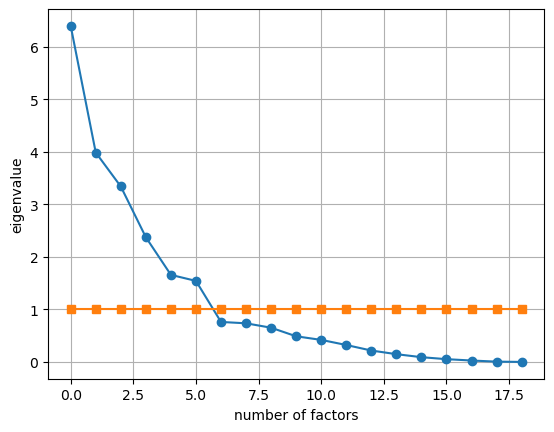

In [25]:
ev = pca.explained_variance_

ev_1 = np.ones(19)

plt.plot(ev, 'o-')
plt.plot(ev_1, 's-')

plt.xlabel("number of factors")
plt.ylabel("eigenvalue")

plt.grid()
plt.show()

In [ ]:
from sklearn.decomposition import FactorAnalysis as FA

n_components = 5

fa = FA(n_components, max_iter=5000)
fitted = fa.fit_transform(z)

print(fitted)
print(fitted.shape)


[[ 1.72892902  0.99867042  0.27346886 -1.19410826  1.22662901]
 [-1.08897041 -1.25114182 -1.18368726 -0.46903143  1.51546982]
 [-0.53136955  1.52583495 -0.43772318  1.31899019  0.06806163]
 [-1.09620604 -0.22734684  2.05896072 -0.9390814  -0.47099112]
 [ 0.03704922  0.31259185  0.17020415  0.88242047 -0.3866064 ]
 [ 1.32103565 -1.32604084 -0.56400311  0.02525396 -1.46137696]
 [-0.69761917  0.75792871 -1.07847085 -1.01124449 -1.12703925]
 [ 0.32715127 -0.79049642  0.76125068  1.38680096  0.63585327]]
(8, 5)


### 因子負荷量行列

In [ ]:
Factor_loading_matrix = fa.components_.T

pd.DataFrame(
    Factor_loading_matrix,
    columns=["first", "second", "third", "fourth", "fifth"],
    index=[fa_data.columns]
)

,first,second,third,fourth,fifth
X1,0.271132,0.478711,0.385791,0.610323,-0.365906
X2,0.653478,-0.012802,-0.429787,-0.395790,-0.277758
X3,0.468605,0.033581,-0.797124,0.124900,0.165770
X4,0.217104,0.053818,-0.069955,-0.879632,-0.149422
X5,0.831532,0.433273,0.242187,0.247136,-0.030089
X6,0.767996,-0.393504,0.180200,0.000682,0.229407
X7,0.710497,-0.435318,0.455114,-0.166911,0.265278
X8,0.196267,0.138487,-0.764934,-0.327941,0.394227
X9,0.197672,0.618745,-0.154232,-0.608118,-0.362394
X10,0.945398,-0.058500,-0.245645,-0.180753,-0.098152


## 定量的分析

### t検定

In [24]:
from scipy.stats import ttest_ind

human = aov_data[aov_data["店員"] == "人"]
robot = aov_data[aov_data["店員"] == "ロボット"]

stat, p = ttest_ind(human["金額"], robot["金額"])

print("t = %f, p-value = %f"%(stat,p))

t = 0.571239, p-value = 0.575313


### 一要因分散分析

In [ ]:
from scipy.stats import f_oneway

f, p = f_oneway(human["金額"], robot["金額"])
print("F = %f, p-value = %f"%(f,p))

F=1.200769, p-value = 0.315192
